In [6]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np 
import pandas as pd 
import scanpy as sc

In [2]:
import sys, os
sys.path.append('../../src')

from interaction import Interaction
from kmer import Kmerizer

In [136]:
x_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_rna_filtered85.csv'
y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'

y = pd.read_csv(y_path)['Y'].values
tcr_embeddings = np.load('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/ESM2_PCA32_KIR+TEDDY.npy')

In [137]:
machop = Interaction(
    slide_outs, 
    plm_embed=tcr_embeddings, y=y,
    interacts_only=False,
    model='LR'
)


In [182]:
beta_interaction = machop.compute(fdr=0.2)
beta_interaction.shape

/ix/djishnu/alw399/envs/otter/lib/python3.10/site-packages/knockpy/mrc.py:276: UserWarning: 
	---------------------------------------------------------
	---------------------------------------------------------
	The choldate package is not installed:
	solving for MVR or maxent knockoffs without it will be 
	~5x slower. For instructions on how to install choldate,
	see https://amspector100.github.io/knockpy/installation.html.
	To disable this warning, set choldate_warning=False as an 
	argument or a knockoff_kwarg.
	----------------------------------------------------------
	----------------------------------------------------------

  warnings.warn(constants.CHOLDATE_WARNING)


(6, 32)

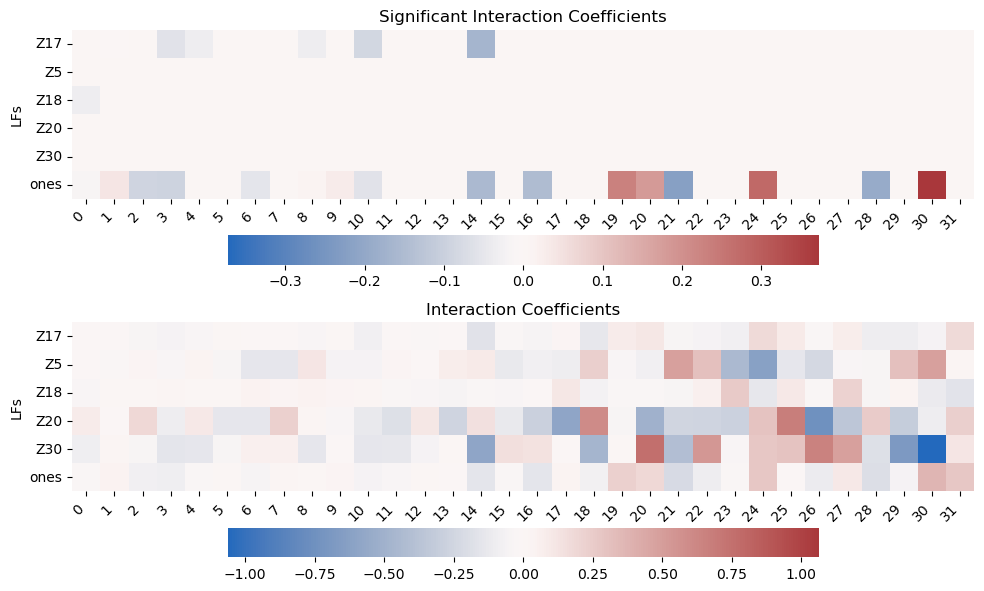

In [183]:
from plotting import show_interactions

show_interactions(machop)

In [184]:
machop.z_matrix.shape, machop.plm_embedding.shape

((10191, 6), (10191, 32))

In [185]:
gex = machop.z_matrix @ machop.sig_interaction
gex.shape

(10191, 32)

In [186]:
plm = machop.plm_embedding @ machop.sig_interaction.T 
plm.shape

(10191, 6)

In [187]:
joint_embed = np.hstack([gex, plm])
joint_embed.shape

(10191, 38)

In [188]:
# from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

In [192]:
model = Lasso(alpha=0.05)
# model = LinearRegression()

In [193]:
estimator = Estimator(model=model)
scores = estimator.evaluate(joint_embed, y)
auc = np.mean(scores)
auc

0.6188330226402646

In [194]:
estimator = Estimator(model=model)
scores = estimator.evaluate(machop.z_matrix, y)
auc = np.mean(scores)
auc

0.7877771459206832

In [ ]:
# from deletion import EmbeddingEvaluator

# evaluator = EmbeddingEvaluator()
# accuracies = evaluator.get_contributions(
#     embedding=machop.plm_embedding, 
#     y=machop.y
# )